In [1]:

import pandas as pd 
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import StratifiedKFold,  GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import gc



# Метод одной модели

In [2]:

df= pd.read_csv(r'D:\Documents\GitHub\MastersDegree\Datasets\X5\data\X5_clients_data_train.csv')

In [3]:
df.describe()

,MeanChk,MeanItemCost,Chks,last_chk_ago,Mean_TOP_1_BRAND,Mean_TOP_2_BRAND,Mean_TOP_3_BRAND,Mean_TOP_4_BRAND,Mean_TOP_5_BRAND,Mean_TOP_1_VENDOR,...,Mean_TOP_4_LVL,Mean_alc,Mean_CTM,Mean_netto,Mean_diffs,age,NewComerFlag,Gender,treatment_flg,target
count,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,...,200039.000000,200039.000000,200039.000000,200039.000000,196219.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000
mean,495.783222,84.241407,20.120821,5.828868,0.131215,0.045033,0.057777,0.044185,0.038410,0.148765,...,0.000164,0.025098,0.148765,3.512542,8.900076,46.417329,1.530102,-0.296547,0.499808,0.619889
std,374.548483,47.634880,17.732130,5.668016,0.097788,0.065461,0.055120,0.044964,0.054367,0.097857,...,0.002905,0.062164,0.097857,3.508437,10.557729,49.532475,0.651553,0.737329,0.500001,0.485415
min,1.040000,0.065000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-7491.000000,0.000000,-1.000000,0.000000,0.000000
25%,261.290000,61.827298,8.000000,1.000000,0.063268,0.000000,0.021877,0.007092,0.002709,0.083333,...,0.000000,0.000000,0.083333,1.914694,3.000000,34.000000,1.000000,-1.000000,0.000000,0.000000
50%,393.999846,76.025910,15.000000,4.000000,0.112962,0.022523,0.046759,0.031716,0.022222,0.133333,...,0.000000,0.000000,0.133333,2.828375,6.000000,45.000000,2.000000,0.000000,0.000000,1.000000
75%,608.740000,95.502247,27.000000,9.000000,0.177366,0.059259,0.078789,0.070426,0.051314,0.194444,...,0.000000,0.021611,0.194444,4.206917,10.000000,59.000000,2.000000,0.000000,1.000000,1.000000
max,7694.000000,4426.800000,320.000000,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.500000,1.000000,1.000000,299.302000,113.000000,1852.000000,2.000000,1.000000,1.000000,1.000000


In [4]:
med = df.age.median()
df.age = df.age.apply(lambda x: x if((x >= 16) and (x <= 90)) else med)
df.age = df.age.fillna(med)
df.Mean_diffs = df.Mean_diffs.fillna(df.Mean_diffs.median()) 
df = df.fillna(0)

In [5]:
df.describe()

,MeanChk,MeanItemCost,Chks,last_chk_ago,Mean_TOP_1_BRAND,Mean_TOP_2_BRAND,Mean_TOP_3_BRAND,Mean_TOP_4_BRAND,Mean_TOP_5_BRAND,Mean_TOP_1_VENDOR,...,Mean_TOP_4_LVL,Mean_alc,Mean_CTM,Mean_netto,Mean_diffs,age,NewComerFlag,Gender,treatment_flg,target
count,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,...,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000,200039.000000
mean,495.783222,84.241407,20.120821,5.828868,0.131215,0.045033,0.057777,0.044185,0.038410,0.148765,...,0.000164,0.025098,0.148765,3.512542,8.844695,46.509161,1.530102,-0.296547,0.499808,0.619889
std,374.548483,47.634880,17.732130,5.668016,0.097788,0.065461,0.055120,0.044964,0.054367,0.097857,...,0.002905,0.062164,0.097857,3.508437,10.463966,15.715009,0.651553,0.737329,0.500001,0.485415
min,1.040000,0.065000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,0.000000,-1.000000,0.000000,0.000000
25%,261.290000,61.827298,8.000000,1.000000,0.063268,0.000000,0.021877,0.007092,0.002709,0.083333,...,0.000000,0.000000,0.083333,1.914694,3.000000,34.000000,1.000000,-1.000000,0.000000,0.000000
50%,393.999846,76.025910,15.000000,4.000000,0.112962,0.022523,0.046759,0.031716,0.022222,0.133333,...,0.000000,0.000000,0.133333,2.828375,6.000000,45.000000,2.000000,0.000000,0.000000,1.000000
75%,608.740000,95.502247,27.000000,9.000000,0.177366,0.059259,0.078789,0.070426,0.051314,0.194444,...,0.000000,0.021611,0.194444,4.206917,10.000000,59.000000,2.000000,0.000000,1.000000,1.000000
max,7694.000000,4426.800000,320.000000,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.500000,1.000000,1.000000,299.302000,113.000000,90.000000,2.000000,1.000000,1.000000,1.000000


In [6]:
df = df.drop(['MeanItemCost', 'NewComerFlag', 'client_id'], axis = 1)

In [7]:
# X = df.iloc[:, 0:-1].set_index('client_id')
# y = df.iloc[:, [0, -1]].set_index('client_id')
# del df
# gc.collect()
treat = df.treatment_flg.values
X = df.iloc[:, 0:-1].values
X = (X - X.mean()) / X.std()
y = df.iloc[:, -1].values
del df
gc.collect()

43

In [8]:
X

array([[ 2.45235854,  0.08675556, -0.14104325, ...,  0.12180153,
        -0.18485071, -0.16732773],
       [ 1.50965564, -0.06218982, -0.14104325, ...,  0.43721526,
        -0.16732773, -0.16732773],
       [ 4.26233897, -0.05342832, -0.15856623, ...,  0.33207735,
        -0.17608922, -0.17608922],
       ...,
       [ 3.22704298, -0.06218982, -0.13228176, ...,  0.30579287,
        -0.18485071, -0.16732773],
       [ 1.27283746,  0.41969227, -0.17608922, ...,  0.3934078 ,
        -0.18485071, -0.16732773],
       [ 1.46038998,  0.02542511, -0.05342832, ...,  0.00790212,
        -0.17608922, -0.17608922]])

In [9]:
y

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [10]:
# X_train, X_test, y_train, y_test = train_test_split(X, y)

In [11]:
# output.enable_custom_widget_manager()
# grid = {'learning_rate':  np.linspace(0, 0.05, 10)[1:-1],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5, 7, 9]}
# clf = CatBoostClassifier(verbose = 0)  
# grid_search_result = clf.grid_search(grid, 
#                                        X=X_train, 
#                                        y=y_train, 
#                                        plot=True)

In [12]:
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt



Split 1; WAU = 0.011673089811542511
Split 2; WAU = 0.0036379007267297505
Split 3; WAU = 0.01764279509148673
Split 4; WAU = 0.013267391959644327
Split 5; WAU = 0.014065659800807508


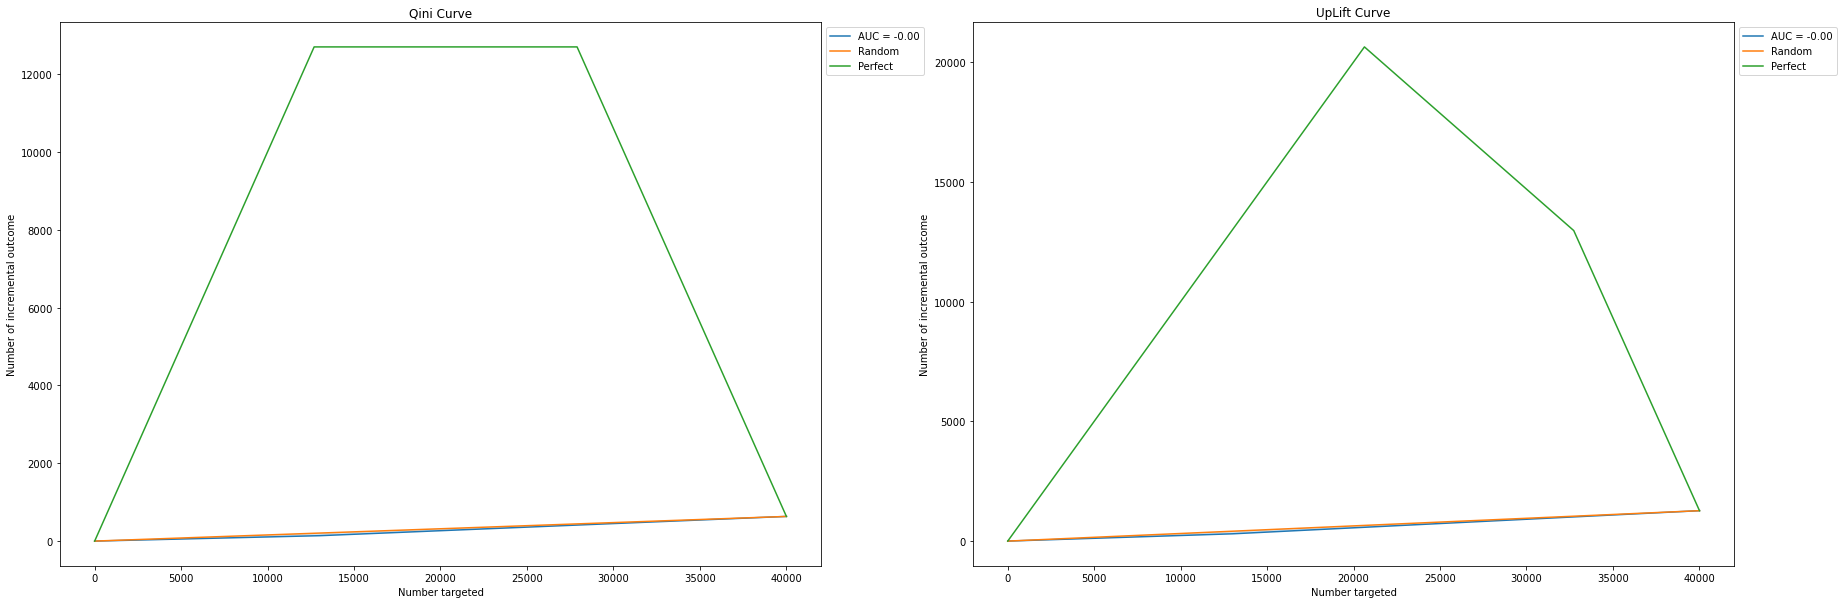

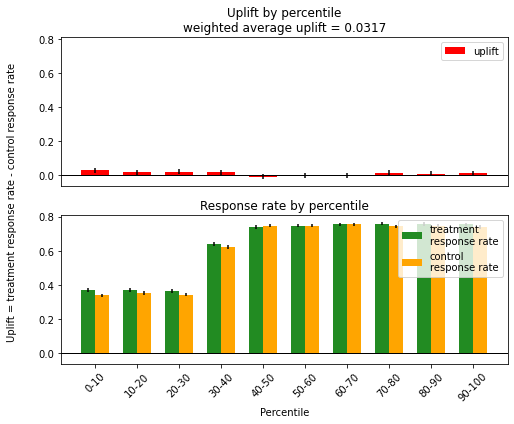

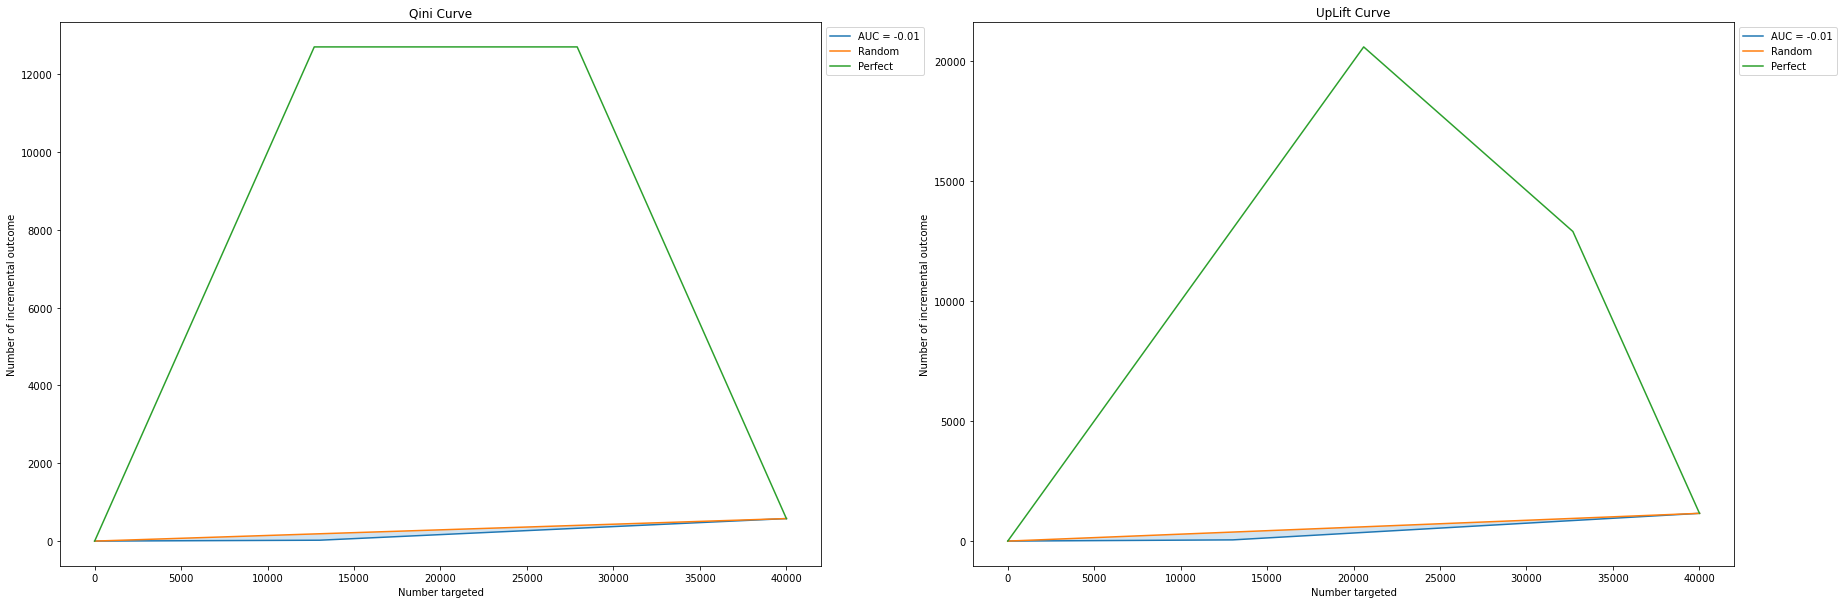

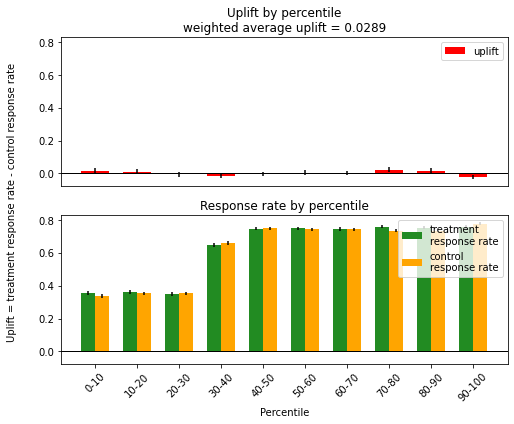

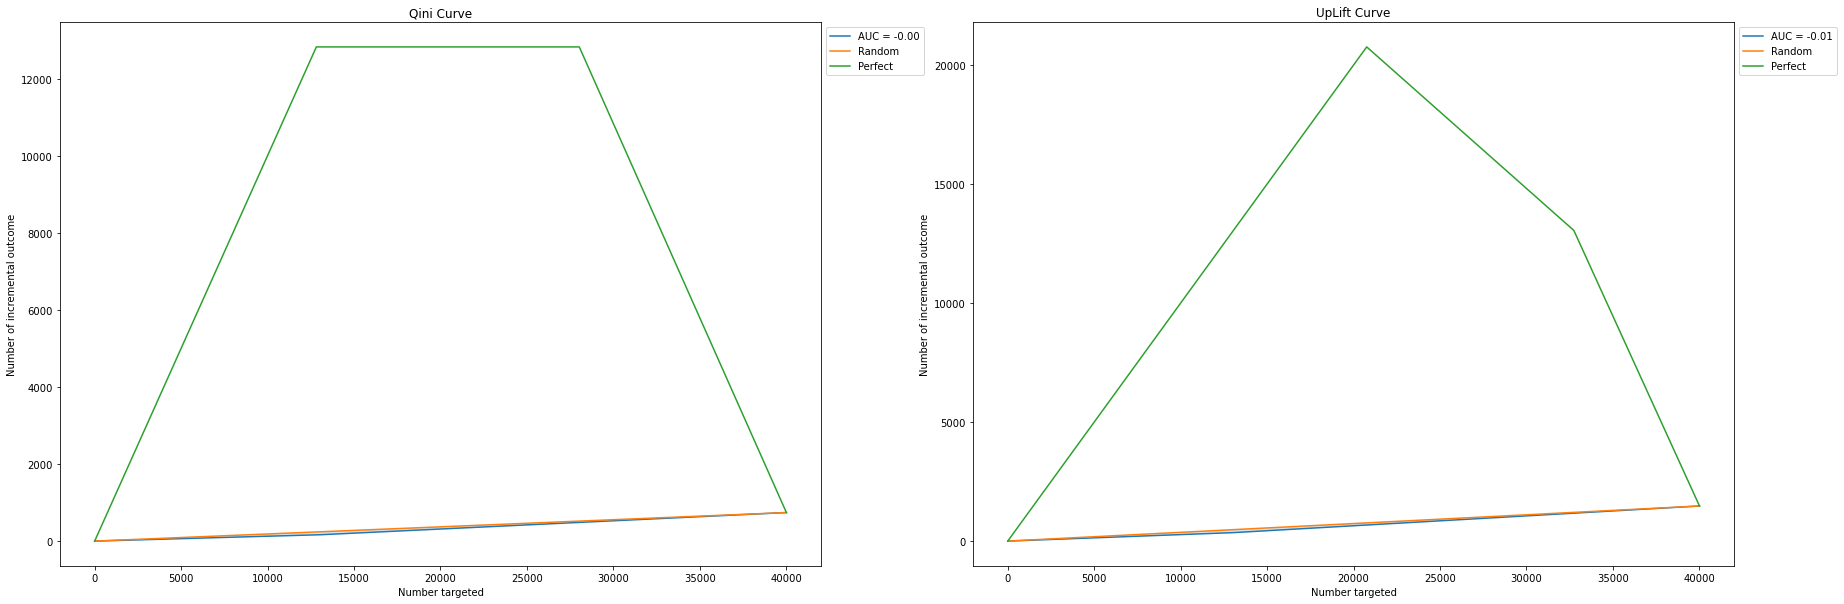

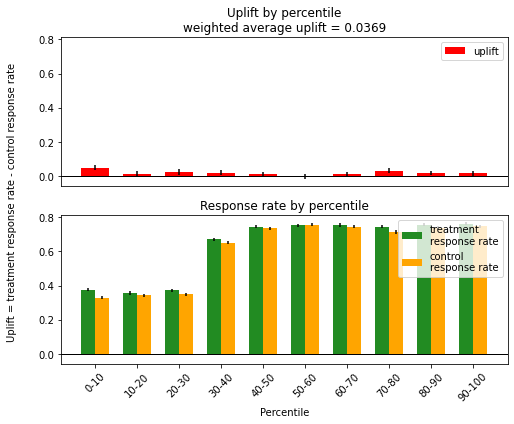

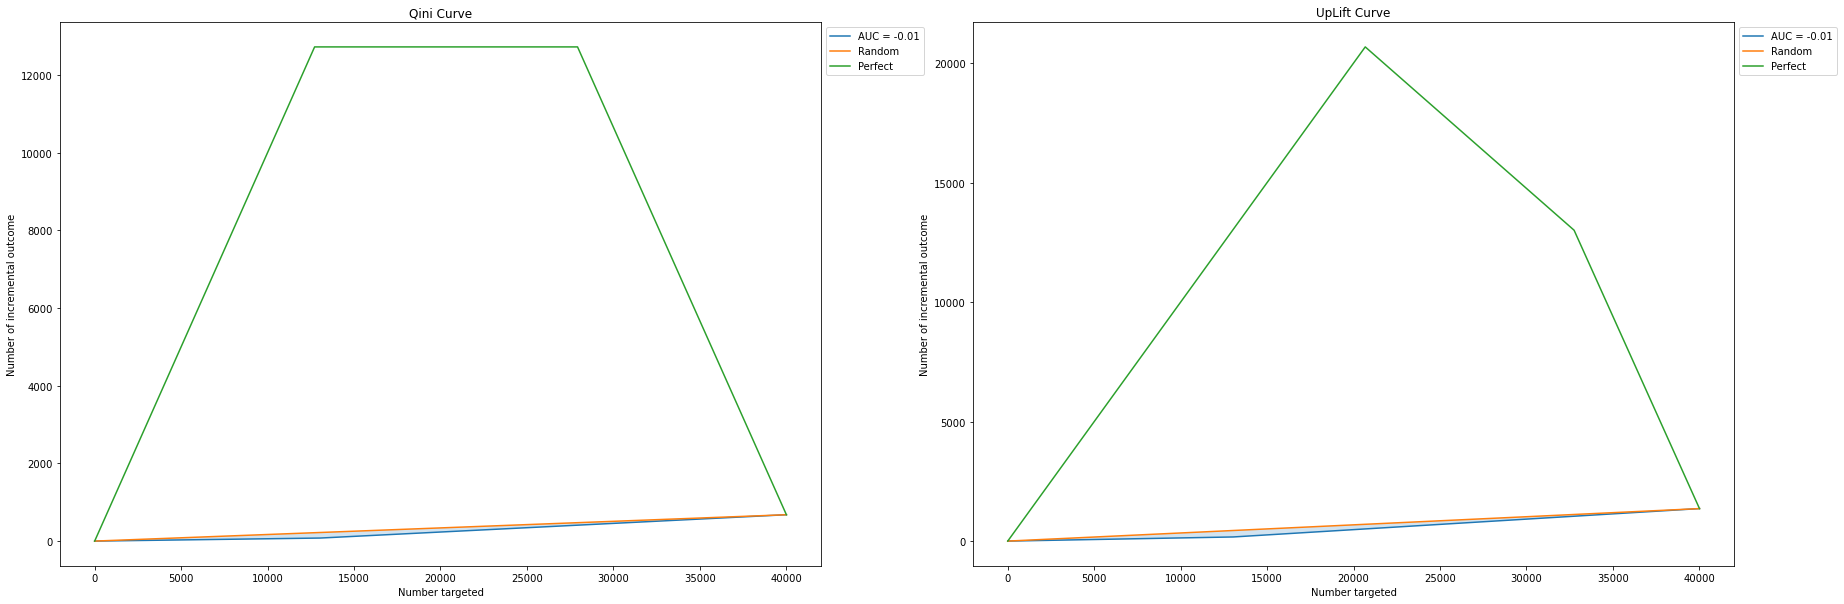

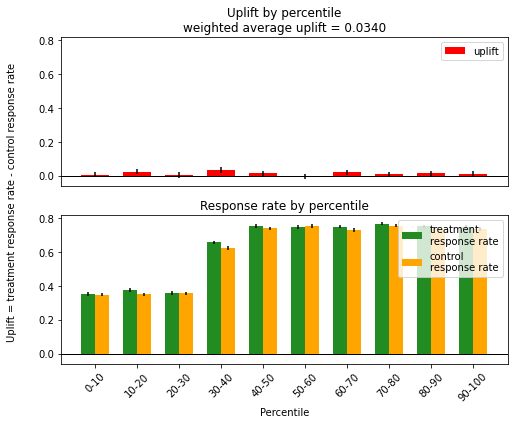

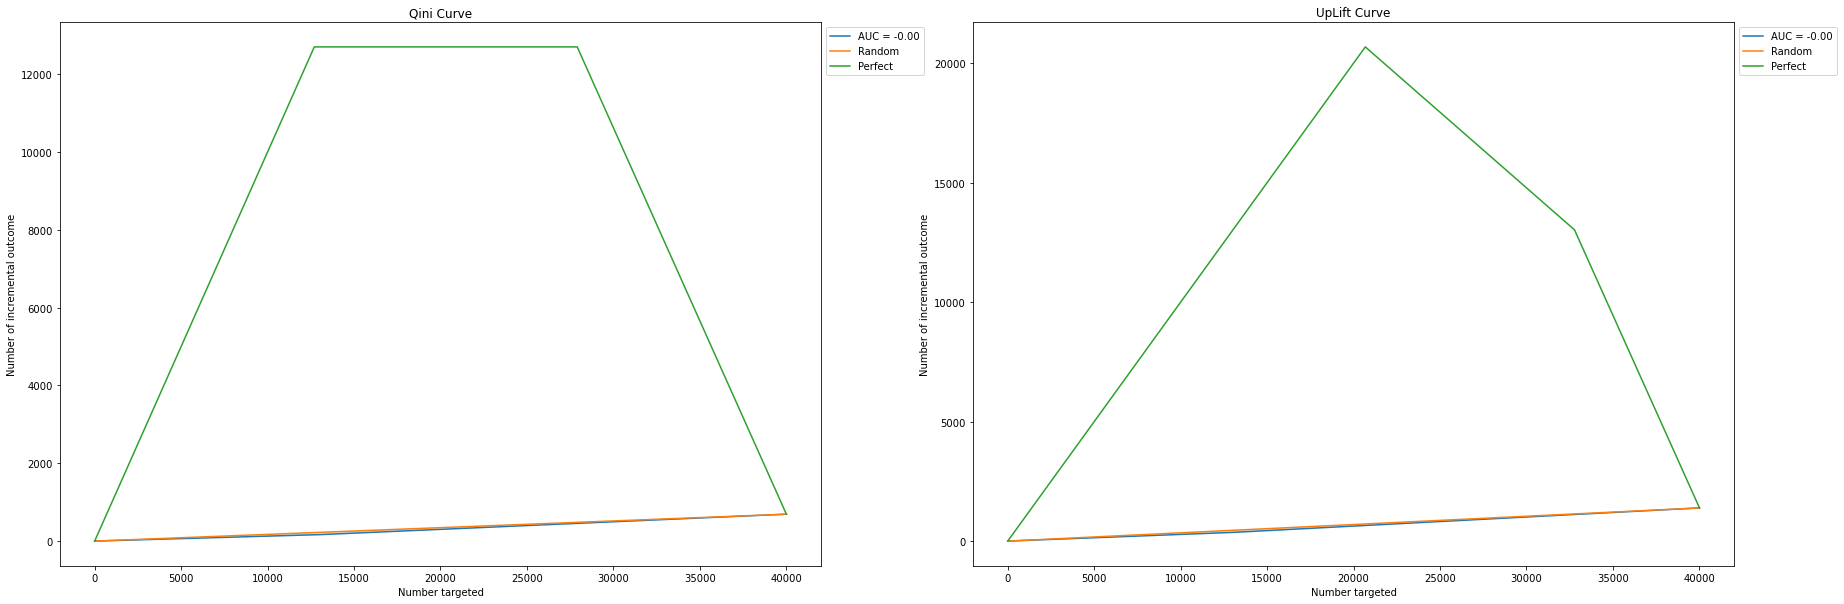

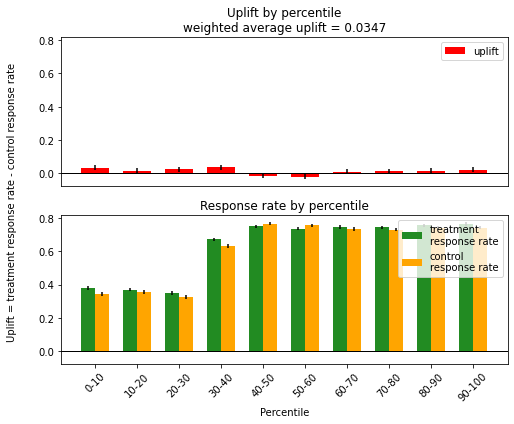

In [13]:
#Default data
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = []
i = 0


for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      clf = CatBoostClassifier(verbose = 0)
      clf.fit(X_train_, y_train_)
      y_pred = np.round(clf.predict_proba(X_test_)).T[0].tolist()
      del clf
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      wau = weighted_average_uplift(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index])
      metrics.append(wau)
      i += 1
      print(f'Split {i}; WAU = {wau}')
      fig, ax = plt.subplots(1, 2, figsize = (30, 10))
      ax[0].set_title('Qini Curve')
      ax[1].set_title('UpLift Curve')
      plot_qini_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[0])
      gc.collect()
      plot_uplift_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[1])
      gc.collect()
      gc.collect()
      gc.collect()
      plt.savefig(f"Plots/One model Split {i}.png")

      plot_uplift_by_percentile(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], kind='bar')
      plt.savefig(f"Plots/One model Procentile Split {i}.png")



In [14]:
metrics = np.array(metrics)
print(f'Mean WAU = {np.round(np.mean(metrics), 4)}')

Mean WAU = 0.0121


In [15]:
gc.collect()

67895

# Метод двух моделей

In [16]:


df= pd.read_csv(r'D:\Documents\GitHub\MastersDegree\Datasets\X5\data\X5_clients_data_train.csv')
df.describe()
med = df.age.median()
df.age = df.age.apply(lambda x: x if((x >= 16) and (x <= 90)) else med)
df.age = df.age.fillna(med)
df.Mean_diffs = df.Mean_diffs.fillna(df.Mean_diffs.median()) 
df = df.fillna(0)
df.describe()

df = df.drop(['MeanItemCost', 'NewComerFlag', 'client_id'], axis = 1)
# X = df.iloc[:, 0:-1].set_index('client_id')
# y = df.iloc[:, [0, -1]].set_index('client_id')
# del df
# gc.collect()
treat = df.treatment_flg.values
X = df.iloc[:, 0:-1].values
X = (X - X.mean()) / X.std()
y = df.iloc[:, -1].values
del df
gc.collect()
X
y
# X_train, X_test, y_train, y_test = train_test_split(X, y)
# output.enable_custom_widget_manager()
# grid = {'learning_rate':  np.linspace(0, 0.05, 10)[1:-1],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5, 7, 9]}
# clf = CatBoostClassifier(verbose = 0)  
# grid_search_result = clf.grid_search(grid, 
#                                        X=X_train, 
#                                        y=y_train, 
#                                        plot=True)
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt







In [17]:

indxs = np.argwhere(X.T[-1] == 0)
indxs

array([], shape=(0, 1), dtype=int64)

Split 1; WAU = 0.0315254402200353
Split 2; WAU = 0.02856744764556056
Split 3; WAU = 0.03668940219328417
Split 4; WAU = 0.034165060699110204
Split 5; WAU = 0.03436803500350623
Mean WAU = 0.0331


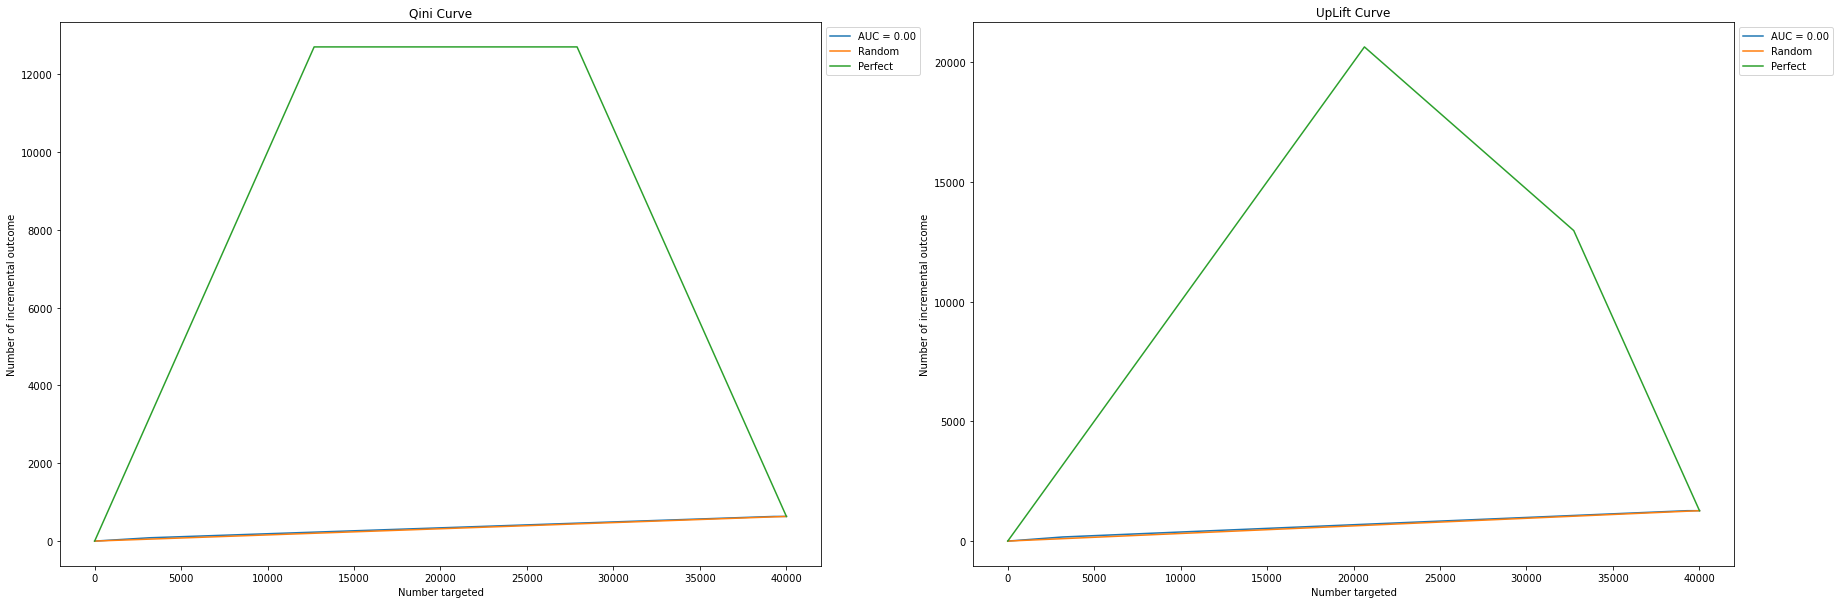

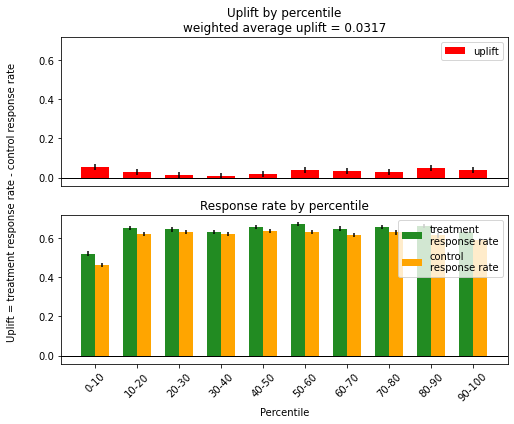

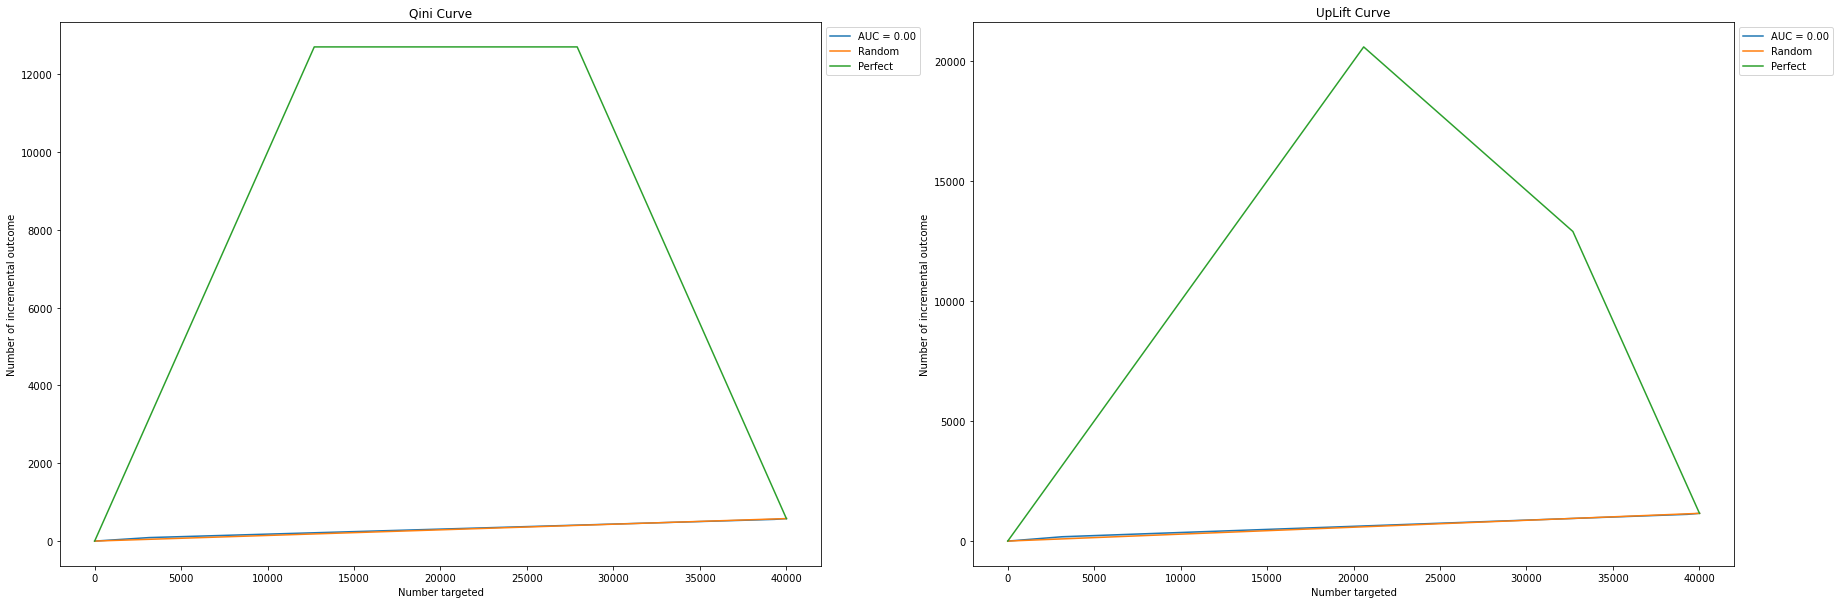

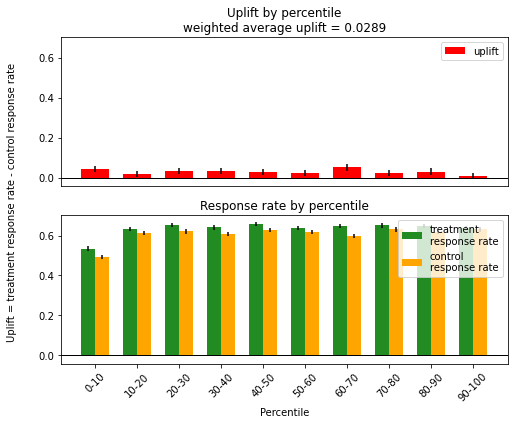

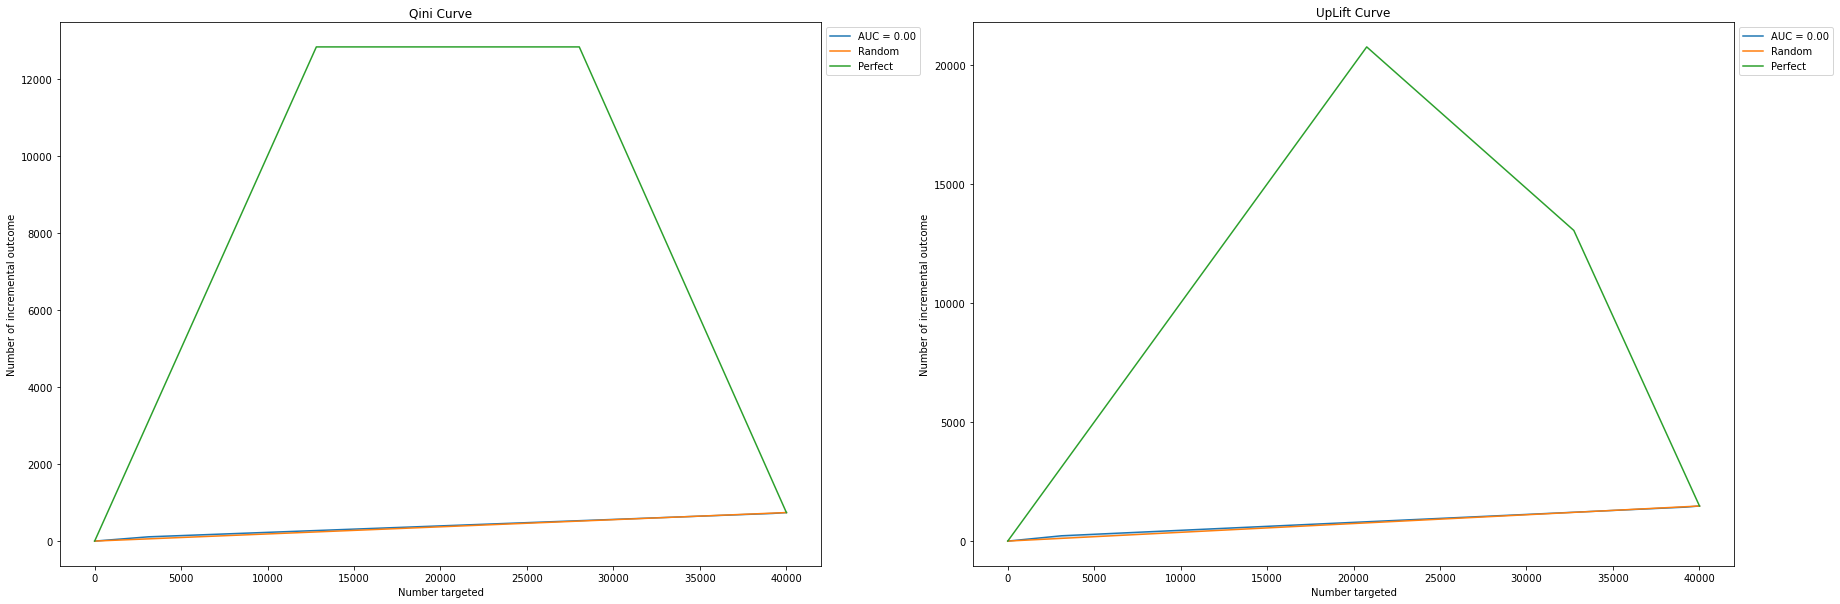

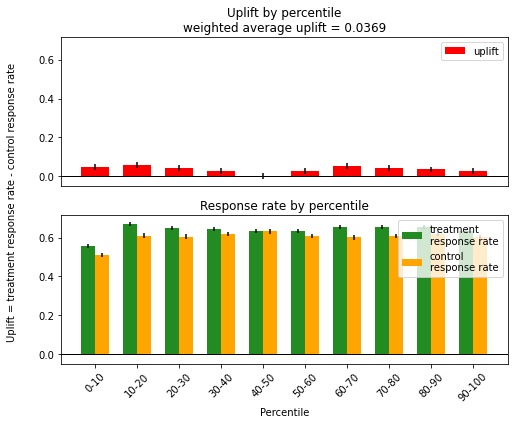

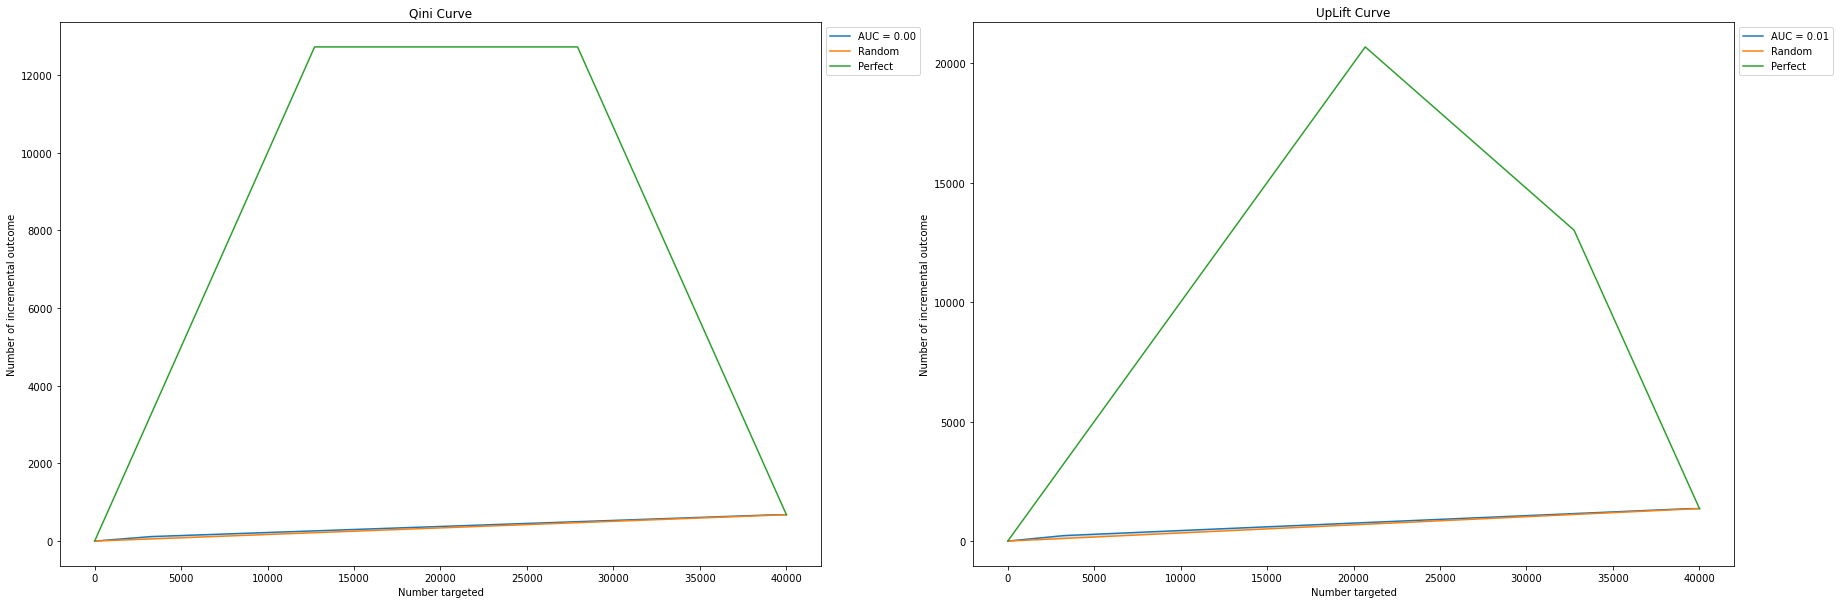

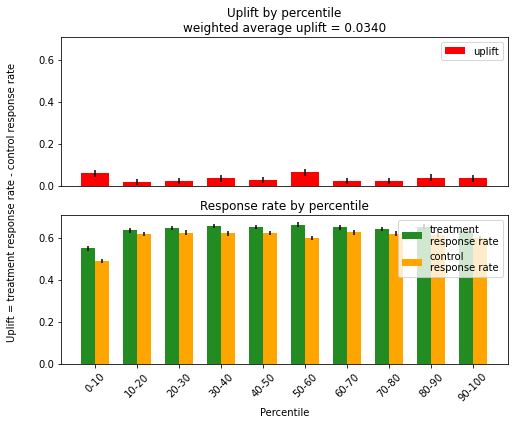

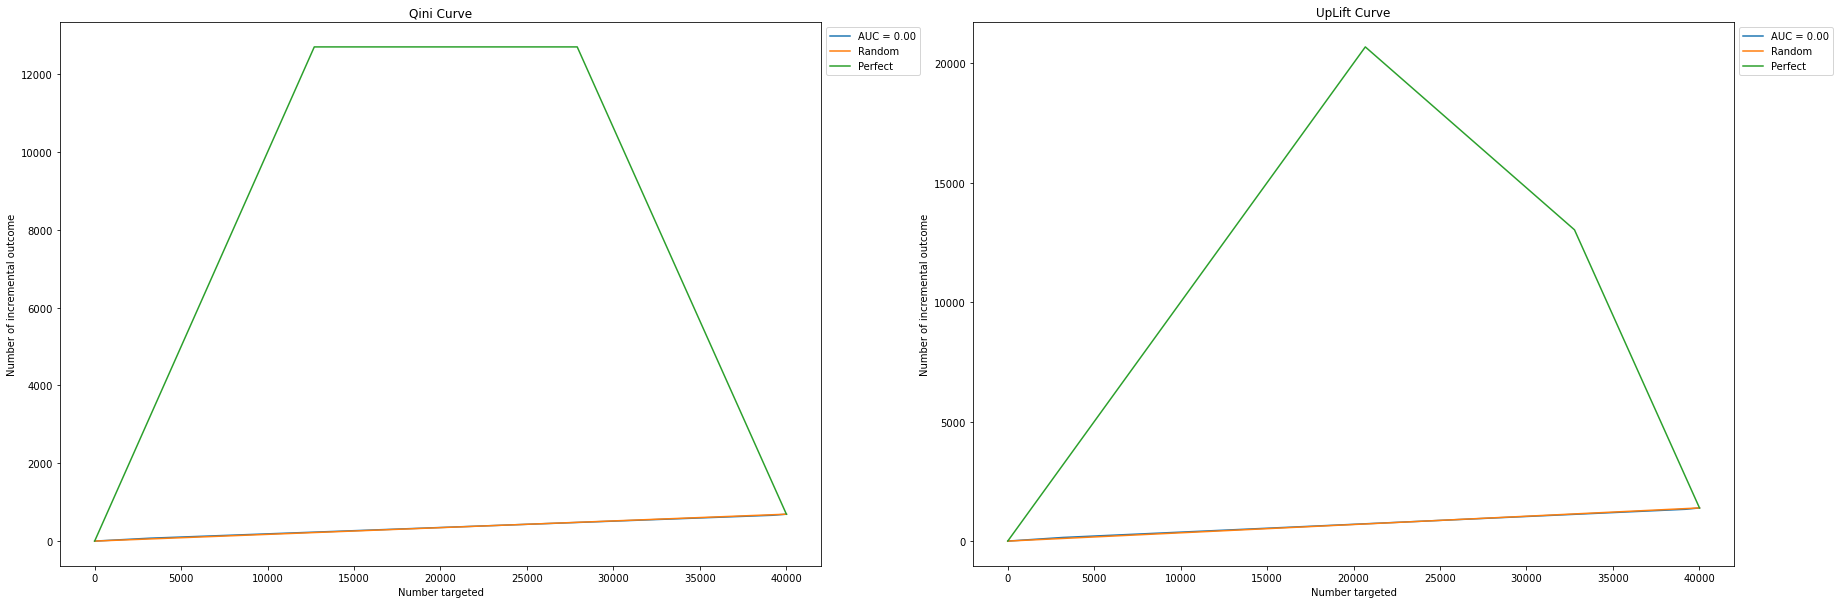

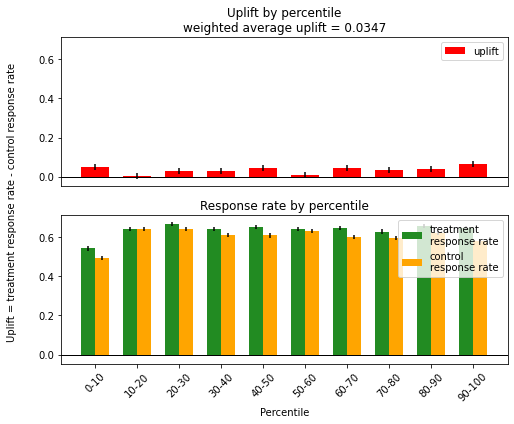

In [19]:
#Default data
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = []
i = 0

for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      t_0 = np.argwhere(treat[train_index] == 0)
      t_1 = np.argwhere(treat[train_index] == 1)
      clf0 = CatBoostClassifier(verbose = 0, class_weights= [0.5, 0.5] )
      clf0.fit(np.squeeze(X_train_[t_0]), np.squeeze(y_train_[t_0]))
      clf1 = CatBoostClassifier(verbose = 0, class_weights= [0.5, 0.5] )
      clf1.fit(np.squeeze(X_train_[t_1]), np.squeeze(y_train_[t_1]))
      y_pred1 = np.round(clf1.predict_proba(X_test_)).T[1]
      y_pred0 = np.round(clf0.predict_proba(X_test_)).T[1]
      y_pred = y_pred1 - y_pred0
      del clf0
      del clf1
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      wau = weighted_average_uplift(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index])
      metrics.append(wau)
      i += 1
      print(f'Split {i}; WAU = {wau}')
      fig, ax = plt.subplots(1, 2, figsize = (30, 10))
      ax[0].set_title('Qini Curve')
      ax[1].set_title('UpLift Curve')
      plot_qini_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[0])
      gc.collect()
      plot_uplift_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[1])
      gc.collect()
      gc.collect()
      gc.collect()
      plt.savefig(f"Plots/Two model Split {i}.png")

      plot_uplift_by_percentile(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], kind='bar')
      plt.savefig(f"Plots/Two model Procentile Split {i}.png")


metrics = np.array(metrics)
print(f'Mean WAU = {np.round(np.mean(metrics), 4)}')

In [ ]:
gc.collect()

# Метод трансформации класса

In [ ]:


df= pd.read_csv(r'D:\Documents\GitHub\MastersDegree\Datasets\X5\data\X5_clients_data_train.csv')
med = df.age.median()
df.age = df.age.apply(lambda x: x if((x >= 16) and (x <= 90)) else med)
df.age = df.age.fillna(med)
df.Mean_diffs = df.Mean_diffs.fillna(df.Mean_diffs.median()) 
df = df.fillna(0)
df.describe()
display(df)







,client_id,MeanChk,MeanItemCost,Chks,last_chk_ago,Mean_TOP_1_BRAND,Mean_TOP_2_BRAND,Mean_TOP_3_BRAND,Mean_TOP_4_BRAND,Mean_TOP_5_BRAND,...,Mean_TOP_4_LVL,Mean_alc,Mean_CTM,Mean_netto,Mean_diffs,age,NewComerFlag,Gender,treatment_flg,target
0,e2652509f4,300.000000,73.065146,30,4,0.096885,0.085866,0.040000,0.102493,0.131647,...,0.0,0.000000,0.349934,2.714800,3.0,34.0,2,-1,1,0
1,7cef4b564e,192.403846,71.013718,13,4,0.211538,0.064103,0.000000,0.000000,0.201282,...,0.0,0.000000,0.166667,1.507615,8.0,70.0,2,1,1,0
2,1292a2aeae,506.583571,90.585577,14,2,0.079762,0.000000,0.048810,0.081548,0.053571,...,0.0,0.008929,0.135119,2.992000,7.0,58.0,2,0,0,0
3,bbadac1567,1172.320000,72.489040,3,20,0.082935,0.084211,0.000000,0.114514,0.084211,...,0.0,0.000000,0.266507,7.598667,17.0,41.0,0,-1,1,0
4,09c55f2885,137.880000,59.411250,40,0,0.416667,0.023750,0.112917,0.000000,0.000000,...,0.0,0.020833,0.095417,1.060850,2.0,18.0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200034,a04b6cc272,262.096774,116.929800,31,5,0.118280,0.036866,0.043318,0.000000,0.089286,...,0.0,0.000000,0.146352,1.340742,3.0,59.0,2,-1,1,0
200035,f570c011c7,251.000000,88.792803,22,1,0.173485,0.074242,0.056061,0.014773,0.023864,...,0.0,0.136364,0.144697,1.893409,4.0,47.0,2,0,1,1
200036,e7ccdb161f,388.419231,80.784188,13,5,0.102564,0.030342,0.070513,0.023810,0.000000,...,0.0,0.044872,0.156716,1.930462,8.0,55.0,2,-1,1,1
200037,b8464507df,165.374412,84.167661,68,0,0.112815,0.014706,0.010294,0.000000,0.175665,...,0.0,0.031863,0.037885,1.116956,1.0,65.0,2,-1,1,1


In [ ]:
df = df.drop(['MeanItemCost', 'NewComerFlag', 'client_id'], axis = 1)
# X = df.iloc[:, 0:-1].set_index('client_id')
# y = df.iloc[:, [0, -1]].set_index('client_id')
# del df
# gc.collect()
treat = df.treatment_flg.values
targ = df.target.values
treat

array([1, 1, 0, ..., 1, 1, 0], dtype=int64)

In [ ]:

p = df[df.treatment_flg == 1].shape[0] / df.shape[0]
X = df.iloc[:, 0:-2].values
X = (X - X.mean()) / X.std()
y = df.target * (df.treatment_flg - p) / (1- p) / p
y = y.values
del df
gc.collect()
print(X)
print(y)
print(p)
# X_train, X_test, y_train, y_test = train_test_split(X, y)
# output.enable_custom_widget_manager()
# grid = {'learning_rate':  np.linspace(0, 0.05, 10)[1:-1],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5, 7, 9]}
# clf = CatBoostClassifier(verbose = 0)  
# grid_search_result = clf.grid_search(grid, 
#                                        X=X_train, 
#                                        y=y_train, 
#                                        plot=True)
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


[[300.          30.           4.         ...   3.          34.
   -1.        ]
 [192.40384615  13.           4.         ...   8.          70.
    1.        ]
 [506.58357143  14.           2.         ...   7.          58.
    0.        ]
 ...
 [388.41923077  13.           5.         ...   8.          55.
   -1.        ]
 [165.37441176  68.           0.         ...   1.          65.
   -1.        ]
 [186.78086957  23.          14.         ...   4.          21.
    0.        ]]
[ 0.          0.         -0.         ...  2.00077015  2.00077015
 -1.99923045]
0.4998075375301816


Split 1; WAU = 0.03201581985030934
Split 2; WAU = 0.028937658390170568
Split 3; WAU = 0.03712508066458319
Split 4; WAU = 0.03344705125284953
Split 5; WAU = 0.034024697382080624
Mean WAU = 0.0331


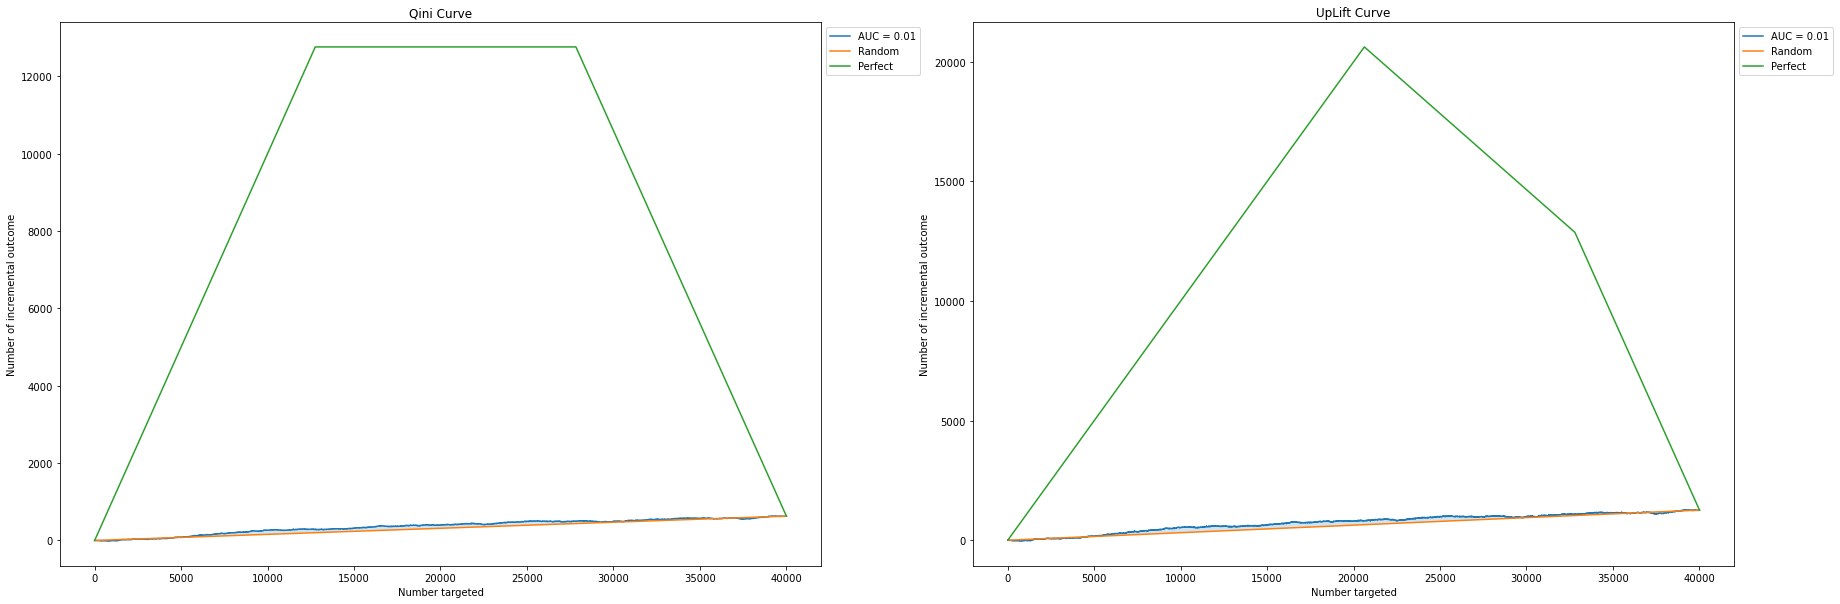

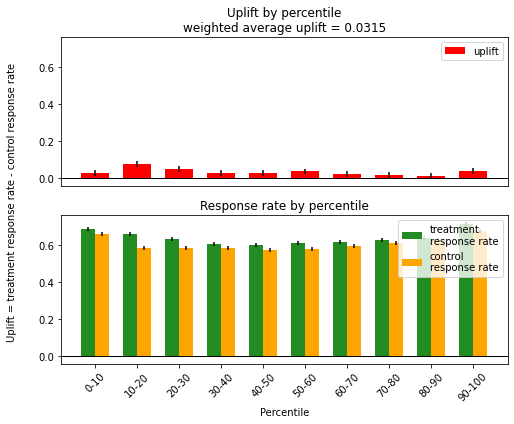

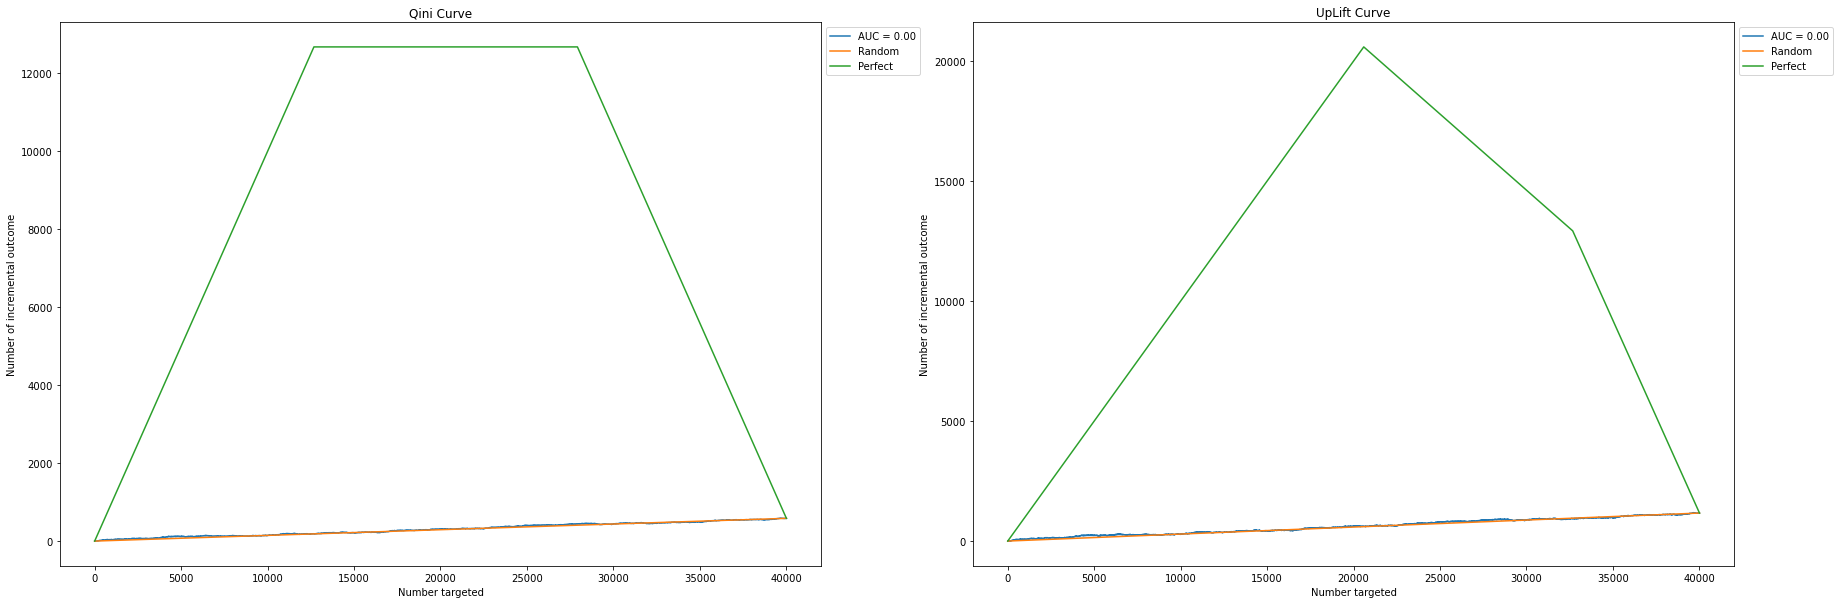

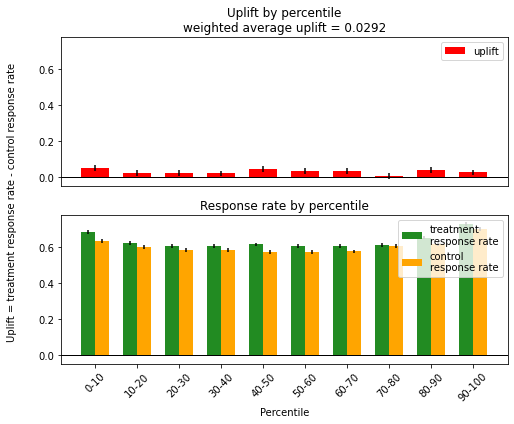

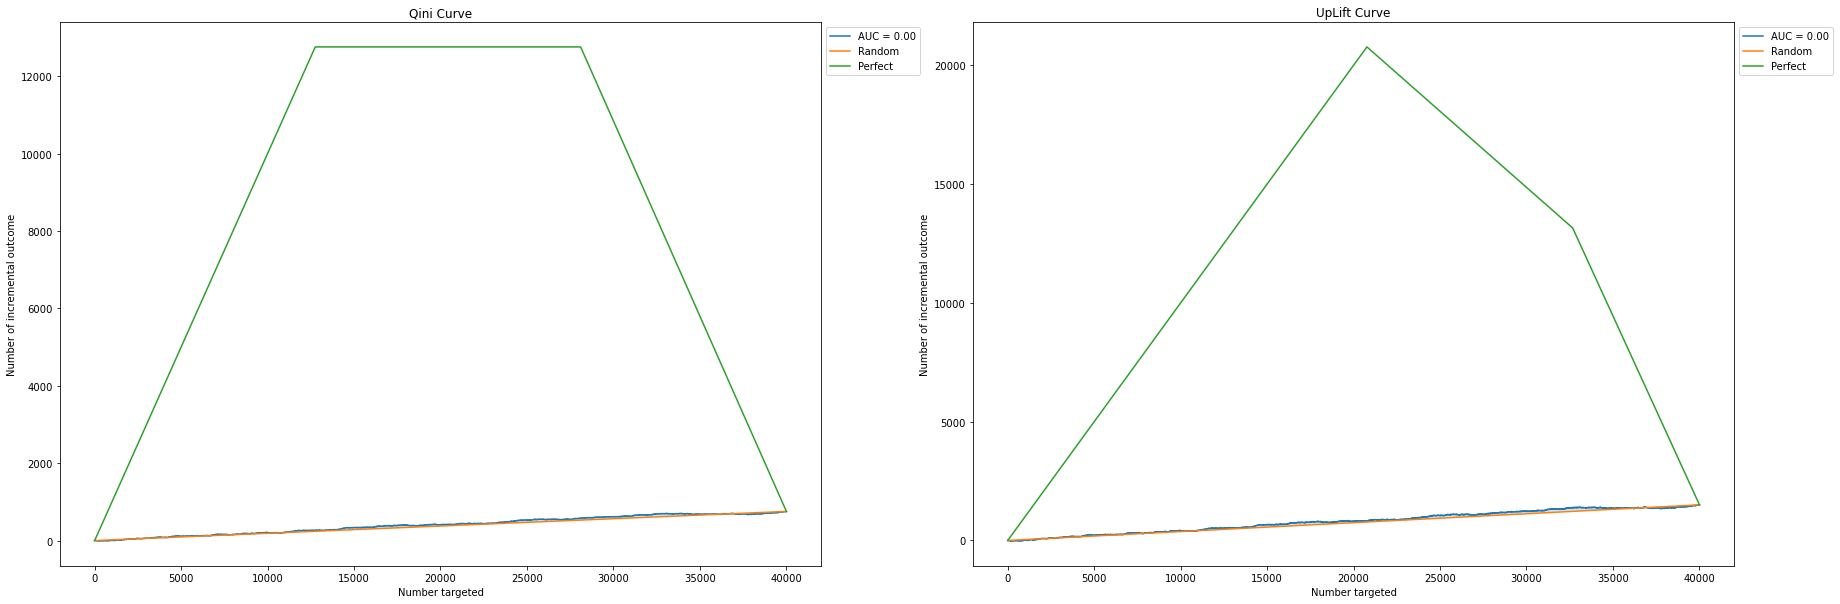

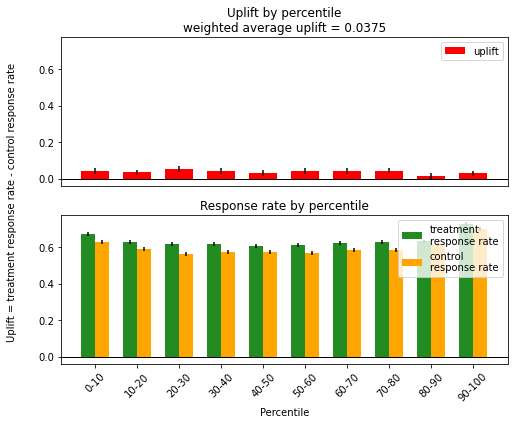

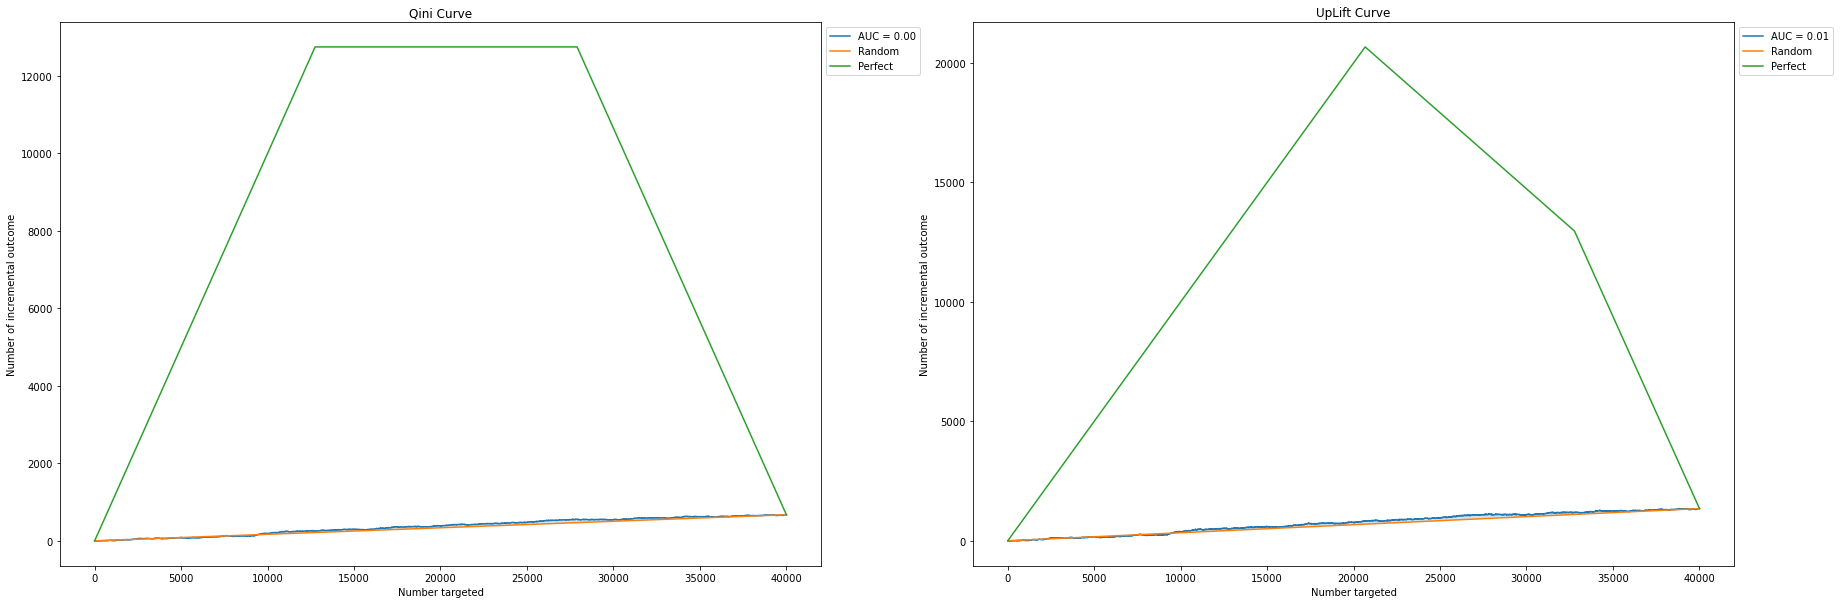

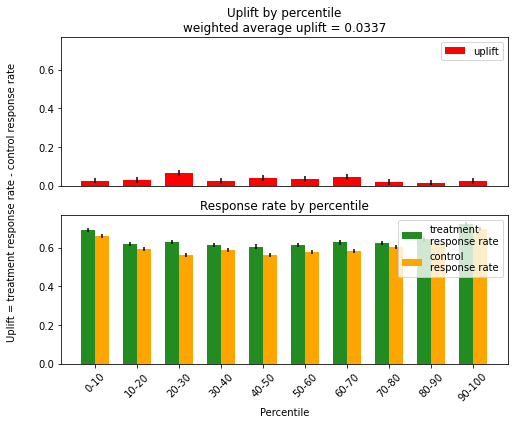

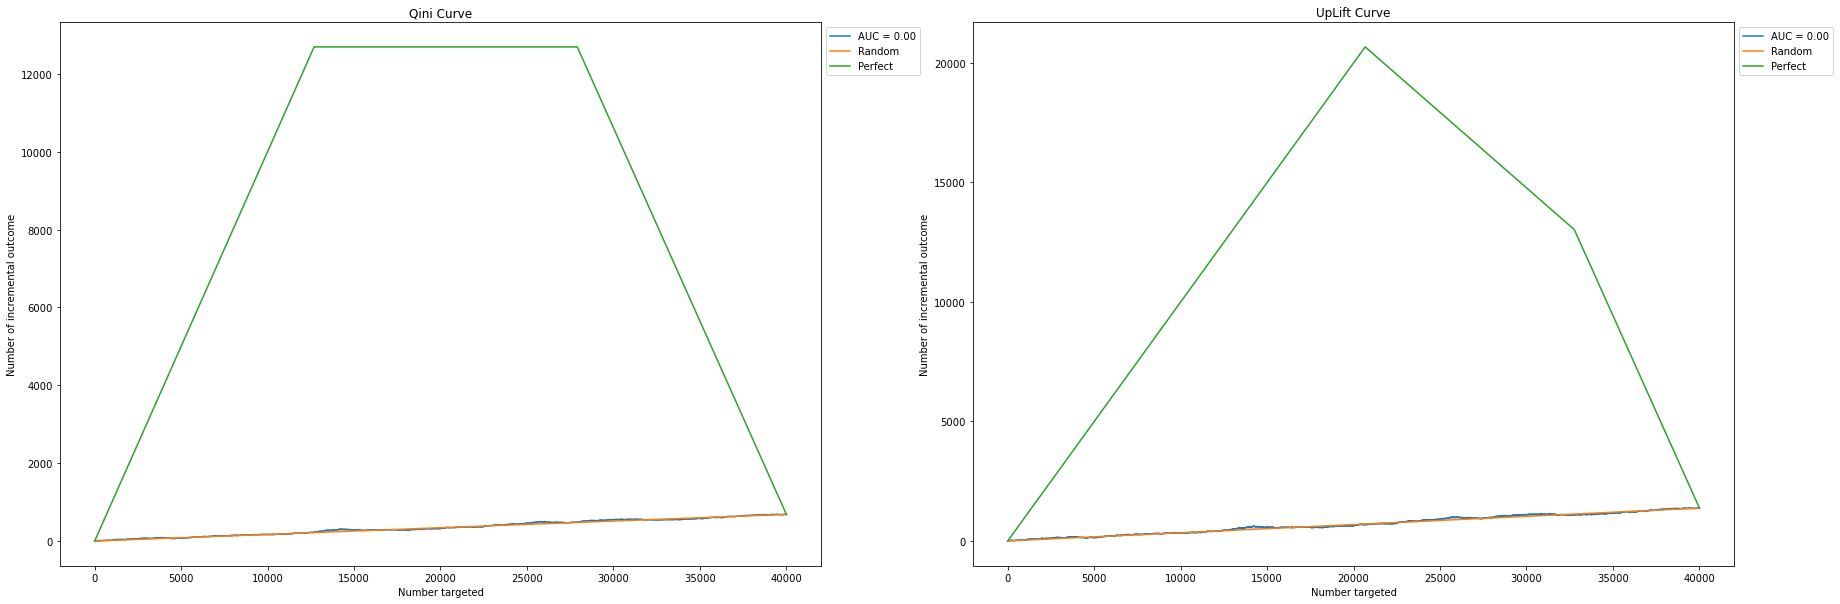

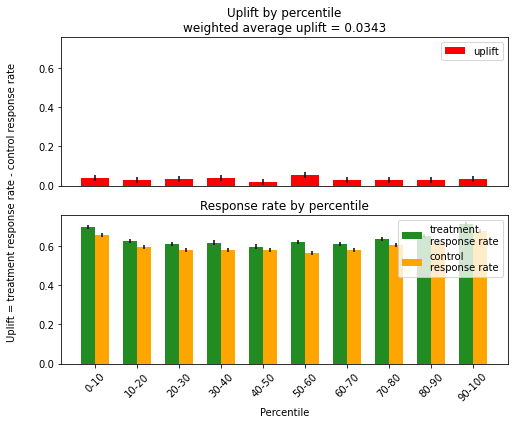

In [ ]:
# Метод двух моделей
#Default data
skf = KFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = []
i = 0

for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      reg = CatBoostRegressor(verbose=0)
      reg.fit(X_train_, y_train_)
      y_pred = reg.predict(X_test_)
      del reg
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      wau = weighted_average_uplift(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index])
      metrics.append(wau)
      i += 1
      print(f'Split {i}; WAU = {wau}')
      fig, ax = plt.subplots(1, 2, figsize = (30, 10))
      ax[0].set_title('Qini Curve')
      ax[1].set_title('UpLift Curve')
      plot_qini_curve(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[0])
      gc.collect()
      plot_uplift_curve(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[1])
      gc.collect()
      gc.collect()
      gc.collect()
      plt.savefig(f"Plots/Regression model Split {i}.png")

      plot_uplift_by_percentile(y_true=targ[test_index], uplift=y_pred,
                              treatment=treat[test_index], kind='bar')
      plt.savefig(f"Plots/Regression model Procentile Split {i}.png")


metrics = np.array(metrics)
print(f'Mean WAU = {np.round(np.mean(metrics), 4)}')


In [ ]:
gc.collect()